## Customer Purchase Intention Model

In [1]:
import time
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


In [2]:
df_online = pd.read_csv('online_shoppers_intention.csv')
df_online.sample(3).T

11968              3959               1967 
Administrative                     0                  0                  0
Administrative_Duration        0.000           0.000000           0.000000
Informational                      0                  0                  0
Informational_Duration         0.000           0.000000           0.000000
ProductRelated                     4                  3                 24
ProductRelated_Duration       57.000          34.000000         580.200000
BounceRates                    0.050           0.000000           0.000000
ExitRates                      0.075           0.066667           0.012121
PageValues                     0.000           0.000000          17.125455
SpecialDay                     0.000           0.000000           0.000000
Month                            Nov                May                Mar
OperatingSystems                   1                  1                  2
Browser                            1                  1                  2
Region                             1                  6                  1
TrafficType                        8                  3                  1
VisitorType              New_Visitor  Returning_Visitor  Returning_Visitor
Weekend                        False              False              False
Revenue                        False              False               True

In [3]:
df_online['Weekend'] = df_online['Weekend'].replace((True, False), (1, 0))
df_online['Revenue'] = df_online['Revenue'].replace((True, False), (1, 0))

In [4]:
df_online['Returning_Visitor'] = np.where(df_online['VisitorType']=='Returning_Visitor', 1, 0)
df_online = df_online.drop(columns=['VisitorType'])

In [5]:
ordinal_encoder = OrdinalEncoder()
df_online['Month'] = ordinal_encoder.fit_transform(df_online[['Month']])

In [6]:
df_online['Revenue'].value_counts()

0    10422
1     1908
Name: Revenue, dtype: int64

In [22]:
df_online

Administrative  Administrative_Duration  Informational  \
0                   0                      0.0              0   
1                   0                      0.0              0   
2                   0                      0.0              0   
3                   0                      0.0              0   
4                   0                      0.0              0   
...               ...                      ...            ...   
12325               3                    145.0              0   
12326               0                      0.0              0   
12327               0                      0.0              0   
12328               4                     75.0              0   
12329               0                      0.0              0   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                         0.0               1                 0.000000   
1                         0.0               2                64.000000   
2                         0.0               1                 0.000000   
3                         0.0               2                 2.666667   
4                         0.0              10               627.500000   
...                       ...             ...                      ...   
12325                     0.0              53              1783.791667   
12326                     0.0               5               465.750000   
12327                     0.0               6               184.250000   
12328                     0.0              15               346.000000   
12329                     0.0               3                21.250000   

       BounceRates  ExitRates  PageValues  SpecialDay  Month  \
0         0.200000   0.200000    0.000000         0.0    2.0   
1         0.000000   0.100000    0.000000         0.0    2.0   
2         0.200000   0.200000    0.000000         0.0    2.0   
3         0.050000   0.140000    0.000000         0.0    2.0   
4         0.020000   0.050000    0.000000         0.0    2.0   
...            ...        ...         ...         ...    ...   
12325     0.007143   0.029031   12.241717         0.0    1.0   
12326     0.000000   0.021333    0.000000         0.0    7.0   
12327     0.083333   0.086667    0.000000         0.0    7.0   
12328     0.000000   0.021053    0.000000         0.0    7.0   
12329     0.000000   0.066667    0.000000         0.0    7.0   

       OperatingSystems  Browser  Region  TrafficType  Weekend  Revenue  \
0                     1        1       1            1        0        0   
1                     2        2       1            2        0        0   
2                     4        1       9            3        0        0   
3                     3        2       2            4        0        0   
4                     3        3       1            4        1        0   
...                 ...      ...     ...          ...      ...      ...   
12325                 4        6       1            1        1        0   
12326                 3        2       1            8        1        0   
12327                 3        2       1           13        1        0   
12328                 2        2       3           11        0        0   
12329                 3        2       1            2        1        0   

       Returning_Visitor  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
12325                  1  
12326                  1  
12327                  1  
12328                  1  
12329                  0  

[12330 rows x 18 columns]

<AxesSubplot:>

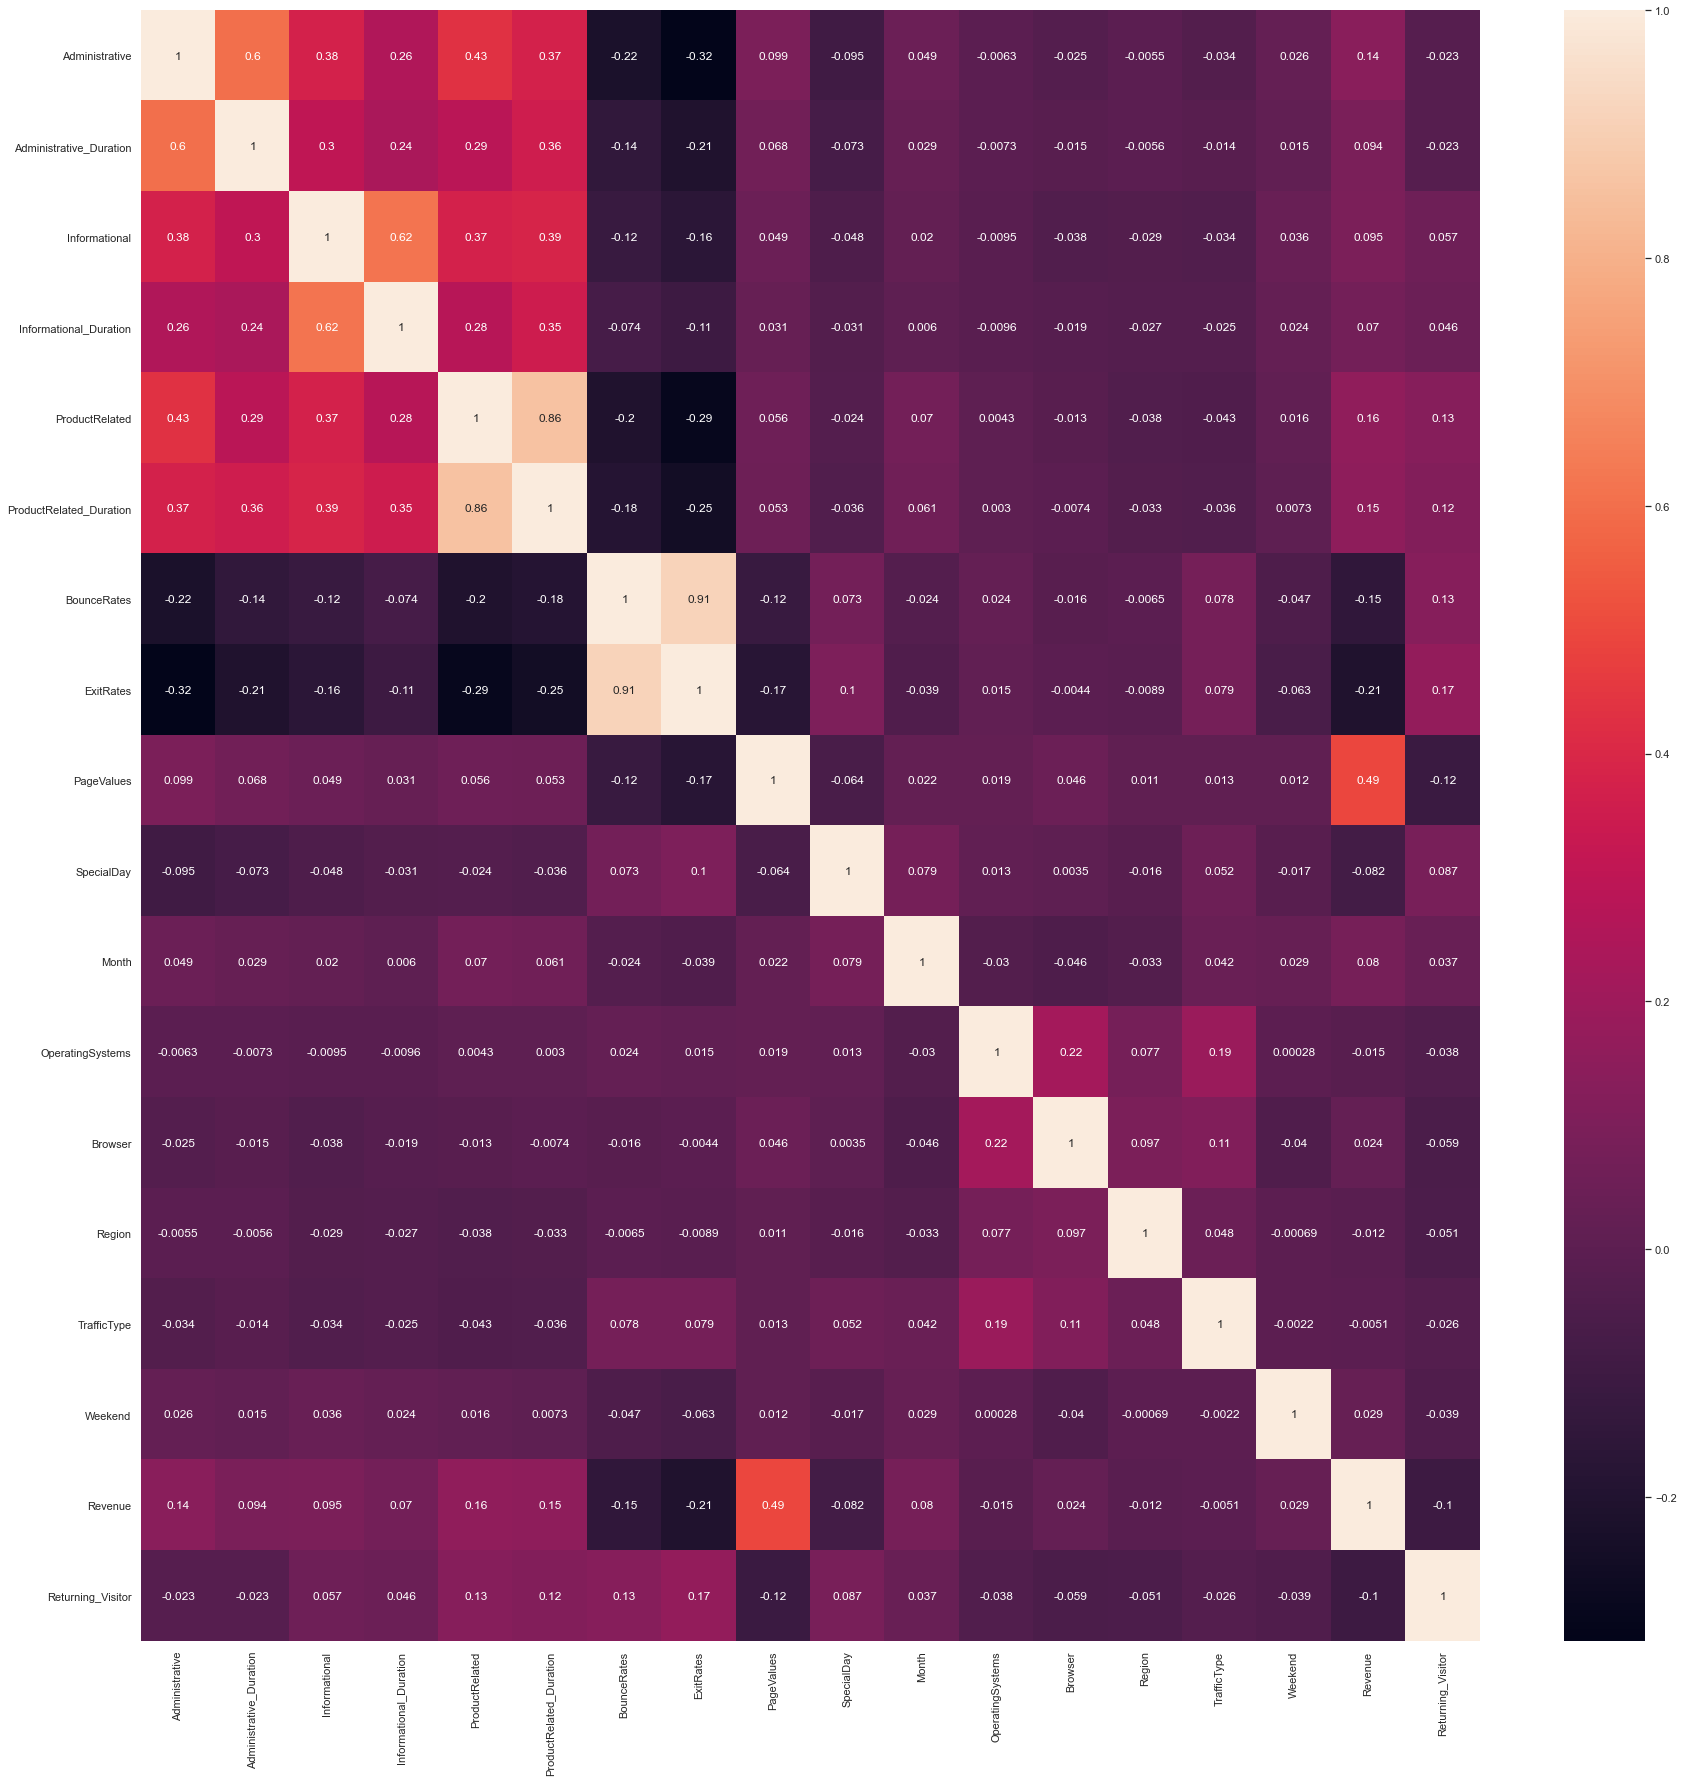

In [7]:
sns.set(rc={'figure.figsize':(30, 30)})
sns.heatmap(df_online.corr(), annot=True)

In [8]:
X = df_online.drop(['Revenue'], axis=1)
y = df_online['Revenue']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=0,
                                                    stratify=y
                                                   )

In [10]:
def go_inside_pipeline(X, model):
    """Retourne un pipeline pour prétraitement des données et les regrouper avec un modèle.
    
    Arguments:
        X : donnee apprentissaqge 
        model (object): scikit-learn model object
    
    Retour: 
    les  etapes du pipeline. 
    """
    
    num_columns = list(X.select_dtypes(exclude=['object']).columns.values.tolist())    
    categ_columns = list(X.select_dtypes(include=['object']).columns.values.tolist())
    num_pipeline = SimpleImputer(strategy='constant')
    categ_pipeline = OneHotEncoder(handle_unknown='ignore')
    #MinMaxScaler()
    

    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', num_pipeline, num_columns),
            ('categorical', categ_pipeline, categ_columns),
            ], remainder='passthrough'
    )
# RFE(estimator=DecisionTreeClassifier(), n_features_to_select=9)RFECV(estimator=XGBClassifier())RandomForestClassifier()
#SMOTE(random_state=1, k_neighbors=4)BorderlineSMOTE(random_state=0)MinMaxScalerStandardScaler
    steps_pipeline = imbpipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote',SMOTE(random_state=1) ),
        ('scaler',StandardScaler()),
        ('feature_selection', RFECV(estimator=DecisionTreeClassifier())),
        
        ('model', model)
    ])
    
    return steps_pipeline

In [11]:
model = XGBClassifier()
test_pipeline = go_inside_pipeline(X_train, model)
test_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  SimpleImputer(strategy='constant'),
                                                  ['Administrative',
                                                   'Administrative_Duration',
                                                   'Informational',
                                                   'Informational_Duration',
                                                   'ProductRelated',
                                                   'ProductRelated_Duration',
                                                   'BounceRates', 'ExitRates',
                                                   'PageValues', 'SpecialDay',
                                                   'Month', 'OperatingSystems',
                                                   'Browser'...
                   

In [12]:
def selectionner_le_meilleur_model(X, y, pipeline=None):
    """Teste un ensemble de  classifieurs and retourne leur performance sur la donnee d'apprentissage.
    
    Arguments:
        X (type object): un dataframe contenant donnee apprentissage. 
        y (type object): un dataframe contenant label d'apprentissage. 
        pipeline (object): Pipeline sortant de go_inside_pipeline().

    Sortie:
        df (object):un dataframe contenant les performances du model et les resul. 
    """
    all_classifiers = {}
    all_classifiers.update({"DummyClassifier": DummyClassifier(strategy='most_frequent')})
    all_classifiers.update({"KNeighborsClassifier": KNeighborsClassifier()})
    all_classifiers.update({"RidgeClassifier": RidgeClassifier()})
    all_classifiers.update({"SGDClassifier": SGDClassifier()})
    all_classifiers.update({"BaggingClassifier": BaggingClassifier()})
    all_classifiers.update({"BernoulliNB": BernoulliNB()})
    all_classifiers.update({"SVC": SVC()})
    all_classifiers.update({"CatBoostClassifier":CatBoostClassifier(silent=True)})
    all_classifiers.update({"XGBClassifier": XGBClassifier(use_label_encoder=False, 
                                                       eval_metric='logloss',
                                                       objective='binary:logistic',
                                                      )})
    all_classifiers.update({"LGBMClassifier": LGBMClassifier()})
    all_classifiers.update({"RandomForestClassifier": RandomForestClassifier()})
    all_classifiers.update({"DecisionTreeClassifier": DecisionTreeClassifier()})
    all_classifiers.update({"ExtraTreeClassifier": ExtraTreeClassifier()})
    all_classifiers.update({"ExtraTreesClassifier": ExtraTreeClassifier()})    
    all_classifiers.update({"AdaBoostClassifier": AdaBoostClassifier()})
    all_classifiers.update({"MLPClassifier1":MLPClassifier()})
    all_classifiers.update({"MLPClassifier2":MLPClassifier(hidden_layer_sizes=(27, 50),
                                                              max_iter=300,
                                                              activation='relu',
                                                              solver='adam',
                                                              random_state=1)})  
    models = []
    models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    models.append(('CatBoostClassifier', CatBoostClassifier(silent=True)))
    models.append(('BaggingClassifier', BaggingClassifier()))
    all_classifiers.update({"VotingClassifier (XGBClassifier, CatBoostClassifier, BaggingClassifier)": VotingClassifier(models)})
    
    
    models = []
    models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    models.append(('CatBoostClassifier', CatBoostClassifier(silent=True)))
    all_classifiers.update({"VotingClassifier (XGBClassifier, CatBoostClassifier)": VotingClassifier(models)})
    
    models = []
    models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    models.append(('LGBMClassifier', LGBMClassifier()))
    all_classifiers.update({"VotingClassifier (XGBClassifier, LGBMClassifier)": VotingClassifier(models)})
    
    models = []
    models.append(('LGBMClassifier', LGBMClassifier()))
    models.append(('CatBoostClassifier', CatBoostClassifier(silent=True)))
    all_classifiers.update({"VotingClassifier (LGBMClassifier, CatBoostClassifier)": VotingClassifier(models)})
    models=[]
    #voting1=VotingClassifier(estimators=[('LGBMClassifier', LGBMClassifier()), 
    #                                     ('CatBoostClassifier', CatBoostClassifier(silent=True))])
    #voting2=VotingClassifier(estimators=[('XGBClassifier', XGBClassifier(use_label_encoder=False,eval_metric='logloss',
    #                                                                     objective='binary:logistic'),('LGBMClassifier',LGBMClassifier()))
    #                                     ])
    #voting3=VotingClassifier(estimators=[
        #('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss',objective='binary:logistic')),
        #('LGBMClassifier', LGBMClassifier()),
        #('CatBoostClassifier', CatBoostClassifier(silent=True))])
    #models.append(('voting1',voting1))
    #models.append(('voting2',voting2))
    #models.append(('voting3',voting3))
    #all_classifiers.update({"ensemblemodel": VotingClassifier(models)})
    
    models = []
    models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    models.append(('LGBMClassifier', LGBMClassifier()))
    models.append(('CatBoostClassifier', CatBoostClassifier(silent=True)))
    all_classifiers.update({"VotingClassifier (XGBClassifier, LGBMClassifier, CatBoostClassifier)": VotingClassifier(models)})
    
    models = []
    models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    models.append(('RandomForestClassifier', RandomForestClassifier()))
    models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
    all_classifiers.update({"VotingClassifier (XGBClassifier, RandomForestClassifier, DecisionTreeClassifier)": VotingClassifier(models)})
    
    models = []
    models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    models.append(('AdaBoostClassifier', AdaBoostClassifier()))
    models.append(('ExtraTreeClassifier', ExtraTreeClassifier()))
    all_classifiers.update({"VotingClassifier (XGBClassifier, AdaBoostClassifier, ExtraTreeClassifier)": VotingClassifier(models)})
    
    
    models = []
    models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    models.append(('ExtraTreesClassifier', ExtraTreesClassifier()))
    all_classifiers.update({"VotingClassifier (XGBClassifier, ExtraTreesClassifier)": VotingClassifier(models)})    
    
    dataframe_models = pd.DataFrame(columns=['Model', 'Time', 'Accuracy'])
    for cle in all_classifiers:
        debut = time.time()

        pipeline = go_inside_pipeline(X_train, all_classifiers[cle])
        
        cv = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
        

        row = {'Model': cle,
               'Time': format(round((time.time() -debut)/60,2)),
               'Accuracy': cv.mean(),
        }

        dataframe_models  = dataframe_models.append(row, ignore_index=True)
        
    dataframe_models  = dataframe_models.sort_values(by='Accuracy', ascending=False)
    return dataframe_models

In [13]:
models = selectionner_le_meilleur_model(X_train, y_train)
models.head(25)

C:\Users\Ibrahim\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ibrahim\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ibrahim\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ibrahim\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ibrahim\anaconda3\lib\site-packages\sklearn\neural_netw

Model  Time  Accuracy
20  VotingClassifier (LGBMClassifier, CatBoostClas...  3.25  0.902169
7                                  CatBoostClassifier  5.62  0.900953
18  VotingClassifier (XGBClassifier, CatBoostClass...   3.8  0.900446
19   VotingClassifier (XGBClassifier, LGBMClassifier)   1.8  0.900243
21  VotingClassifier (XGBClassifier, LGBMClassifie...  3.19  0.900040
24  VotingClassifier (XGBClassifier, ExtraTreesCla...  1.67  0.899432
9                                      LGBMClassifier  1.44  0.899331
8                                       XGBClassifier  1.48  0.897100
10                             RandomForestClassifier  1.65  0.896594
22  VotingClassifier (XGBClassifier, RandomForestC...  1.59  0.895782
17  VotingClassifier (XGBClassifier, CatBoostClass...  4.26  0.895580
23  VotingClassifier (XGBClassifier, AdaBoostClass...  1.44  0.890005
4                                   BaggingClassifier  1.84  0.886152
14                                 AdaBoostClassifier  1.08  0.880881
15                                     MLPClassifier1  3.56  0.876825
6                                                 SVC  2.78  0.875001
3                                       SGDClassifier  1.32  0.872466
16                                     MLPClassifier2  7.95  0.870843
11                             DecisionTreeClassifier  0.95  0.854825
0                                     DummyClassifier  0.95  0.845296
13                               ExtraTreesClassifier  0.83  0.839416
12                                ExtraTreeClassifier  0.95  0.833840
2                                     RidgeClassifier  1.35  0.832925
1                                KNeighborsClassifier  1.89  0.814170
5                                         BernoulliNB  1.86  0.738139

In [32]:
group_models= []
#group_models.append(('XGBClassifier',XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
group_models.append(('LGBMClassifier', LGBMClassifier()))
group_models.append(('CatBoostClassifier', CatBoostClassifier(silent=True)))
#group_models.append(('BaggingClassifier', BaggingClassifier()))
stacked_model = VotingClassifier(group_models)
sortie_pipeline=features_names = go_inside_pipeline(X_train, stacked_model)
sortie_pipeline.fit(X_train, y_train)
#with open('model1.pkl', 'wb') as f:
#    pickle.dump(sortie_pipeline, f)
y_pred = sortie_pipeline.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
#f1_score = f1_score(y_test, y_pred)
print('ROC/AUC:', roc_auc)
print('Accuracy:', accuracy)
print('*****************************')
print(classification_report(y_test, y_pred))

ROC/AUC: 0.7960991749655817
Accuracy: 0.9047039740470397
*****************************
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      2084
           1       0.72      0.64      0.67       382

    accuracy                           0.90      2466
   macro avg       0.83      0.80      0.81      2466
weighted avg       0.90      0.90      0.90      2466



In [33]:
best_features=list(X.columns[features_names.named_steps['feature_selection'].get_support()])
best_features

['Administrative',
 'Administrative_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'ExitRates',
 'PageValues',
 'Month',
 'TrafficType',
 'Returning_Visitor']

In [35]:
#For apps
import pickle
df_app=df_online[best_features]

y = df_online['Revenue']
X_train, X_test, y_train, y_test = train_test_split(df_app, y, 
                                                    test_size=0.2, 
                                                    random_state=0,
                                                    stratify=y
                                                   )
def go_inside_pipeline_for_app(X, model):
    """Retourne un pipeline pour prétraitement des données et les regrouper avec un modèle.
    
    Arguments:
        X : donnee apprentissaqge 
        model (object): scikit-learn model object
    
    Retour: 
    les  etapes du pipeline. 
    """
    
    num_columns = list(X.select_dtypes(exclude=['object']).columns.values.tolist())    
    #categ_columns = list(X.select_dtypes(include=['object']).columns.values.tolist())
    num_pipeline = SimpleImputer(strategy='constant')
    #categ_pipeline = OneHotEncoder(handle_unknown='ignore')
    #MinMaxScaler()
    

    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', num_pipeline, num_columns),
            ], remainder='passthrough'
    )
# RFE(estimator=DecisionTreeClassifier(), n_features_to_select=9)RFECV(estimator=XGBClassifier())RandomForestClassifier()
#SMOTE(random_state=1, k_neighbors=4)BorderlineSMOTE(random_state=0)
    steps_pipeline = imbpipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote',SMOTE(random_state=1) ),
        ('scaler', MinMaxScaler()),
        #('feature_selection', RFE(estimator=DecisionTreeClassifier(), n_features_to_select=9)),
        
        ('model', model)
    ])
    
    return steps_pipeline

group_models = []
#group_models.append(('XGBClassifier',XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
group_models.append(('LGBMClassifier', LGBMClassifier()))
group_models.append(('CatBoostClassifier', CatBoostClassifier(silent=True)))
stacked_model = VotingClassifier(group_models)
sortie_pipeline=features_names = go_inside_pipeline_for_app(X_train, stacked_model)
sortie_pipeline.fit(X_train, y_train)
with open('model_app.pkl', 'wb') as f:
    pickle.dump(sortie_pipeline, f)
y_pred = sortie_pipeline.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
#f1_score = f1_score(y_test, y_pred)
print('ROC/AUC:', roc_auc)
print('Accuracy:', accuracy)
#print('F1 score:', f1_score)

ROC/AUC: 0.7922817577956205
Accuracy: 0.9018653690186537
